# <span style="color:#d64161; font-family: Trebuchet MS; font-size: 50px; font-weight: bold;">Image Classification with CNN</span>

In [23]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [24]:
torch.cuda.is_available()

True

In [25]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu :
  print('CUDA is not available. Training on CPU ...')
else:
  print('CUDA is available! Training on GPU ...')

CUDA is available! Training on GPU ...


In [26]:
num_workers = 0
batch_size = 20
valid_size = 0.2

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10('data', train = True, download = True, transform = transform)
test_data = datasets.CIFAR10('data', train = False, download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
# Obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# <span style="color:#d64161; font-family: Trebuchet MS; font-size: 40px; font-weight: bold;">Train/Test/Validation split</span>

In [28]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)

# Specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [29]:
# Shape of images in a current batch
for images, labels in train_loader:
  print(images.shape)
  break

torch.Size([20, 3, 32, 32])


# <span style="color:#d64161; font-family: Trebuchet MS; font-size: 40px; font-weight: bold;">Display Images</span>

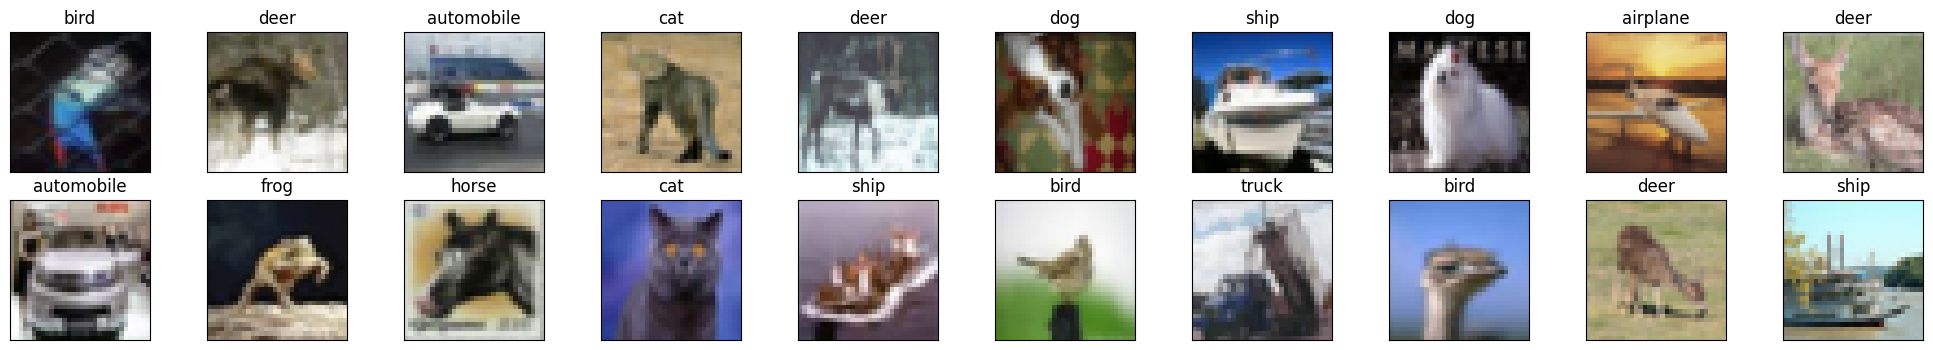

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img) :
  img = img / 2 + 0.5   #unnormalize
  plt.imshow(np.transpose(img, (1, 2, 0)))
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()   # convert images to numpy for display
# plot the imgaes in the batch, along with the corresponding labels
fig = plt.figure(figsize = (25, 4))
# display 20 images
for idx in np.arange(20) :
  ax = fig.add_subplot(2, 20//2, idx+1, xticks = [], yticks = [])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

# <span style="color:#d64161; font-family: Trebuchet MS; font-size: 40px; font-weight: bold;">Channels of an RGB image</span>

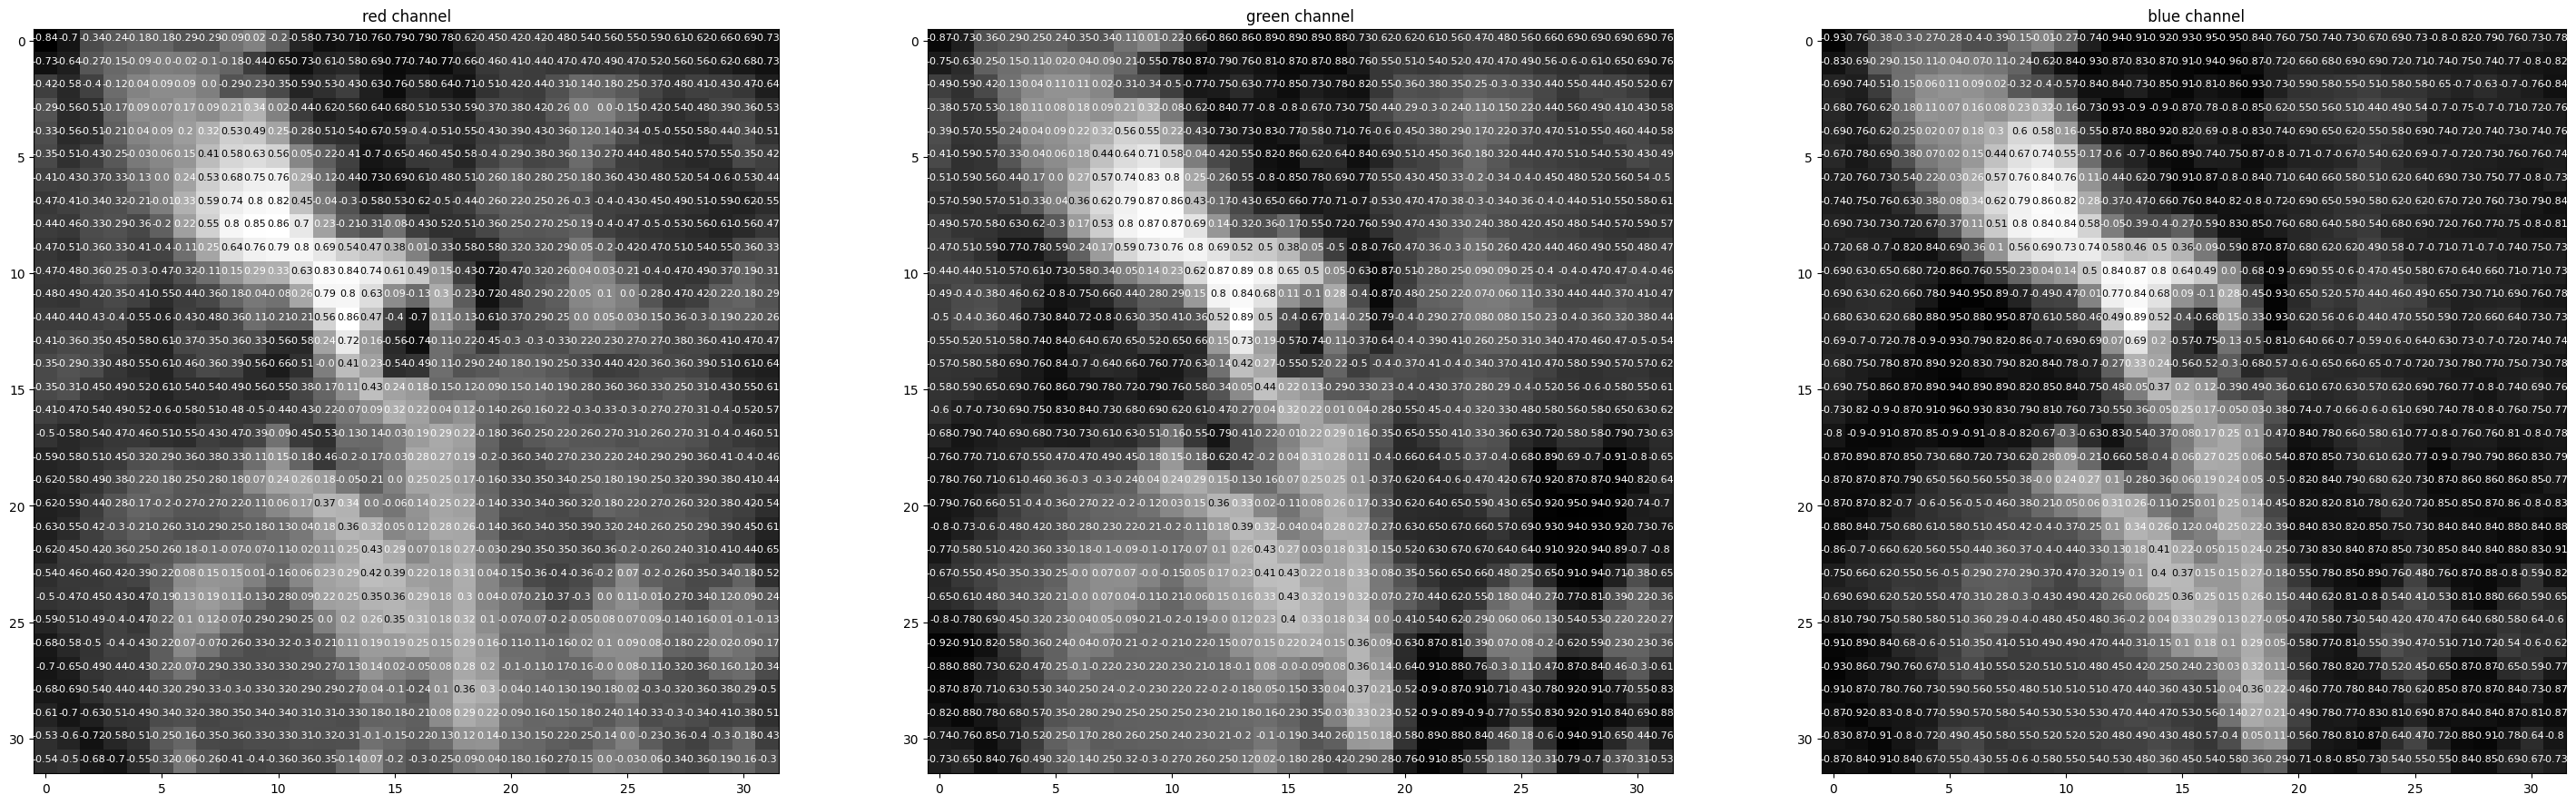

In [9]:
rgb_img = np.squeeze(images[5])
channels = ['red channel', 'green channel',' blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]) :
  ax = fig.add_subplot(1, 3, idx + 1)
  img = rgb_img[idx]
  ax.imshow(img, cmap = 'gray')
  ax.set_title(channels[idx])
  width, height = img.shape
  thresh = img.max() / 2.5
  for x in range(width) :
    for y in range(height) :
      val = round(img[x][y], 2) if img[x][y] != 0 else 0
      ax.annotate(str(val), xy = (y, x),
                  horizontalalignment = 'center', size = 8,
                  color = 'white' if img[x][y] < thresh else 'black' )

# <span style="color:#d64161; font-family: Trebuchet MS; font-size: 40px; font-weight: bold;">Model architecture</span>

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layer
        # Choosing 3 input channels because we have colored images as input
        # 3*32*32 input size
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)

        # Max pooling layer
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected Layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p = .5)

    def forward(self, x):
        # Add sequence of convolutional and max pooling layers
        # 3*32*32
        x = self.pool1(F.relu(self.conv1(x)))
        # 16*32*32 -> 16*16*16
        x = self.pool2(F.relu(self.conv2(x)))
        # [32, 16, 16] -> [32*8*8]
        x = self.pool3(F.relu(self.conv3(x)))
        # 64*8*8 -> 64*4*4
        # Flatten
        x = x.view(-1, 64 * 4 * 4)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [31]:
model = Net()
# Move tensors to GPU if CUDA is available
if train_on_gpu :
    model.cuda()

In [32]:
# Check the model architecture
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [33]:
# How many parameters my model have?
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

get_n_params(model)

581866

In [34]:
# Specify loss function
# Because we have multiclass classification we choose Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
# Specify optimizer
optimizer = optim.SGD(model.parameters(), lr = .01)

# <span style="color:#d64161; font-family: Trebuchet MS; font-size: 40px; font-weight: bold;">Training the model</span>

In [35]:
# Number of epochs to train the model
n_epochs = 30
# List to store loss to visualize
train_losslist = []
valid_loss_min = np.Inf    # Track change in validation loss

for epoch in range(1, n_epochs + 1):
    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    # Train the model
    model.train()
    for data, target in train_loader :
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass : compute predicted outputs by passing inputs to the model
        output = model(data)

        # Calculate the batch loss
        loss = criterion(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Update training loss
        train_loss += loss.item()*data.size(0)

# Validate the model
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
  # Forward pass : compute predicted outputs by passing inputs to the model
        output = model(data)

  # Calculate the batch loss
        loss = criterion(output, target)

  # Update average validation loss
        valid_loss += loss.item()*data.size(0)

  # Calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)

  # Print training/validatuon statistics
    print('Epoch: {} \tTraining Loss: {:.6f}  \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

  # Save the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation Loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.824436  	Validation Loss: 0.424167
Validation Loss decreased (inf --> 0.424167).  Saving model ...
Epoch: 2 	Training Loss: 1.604136  	Validation Loss: 0.360523
Validation Loss decreased (0.424167 --> 0.360523).  Saving model ...
Epoch: 3 	Training Loss: 1.411012  	Validation Loss: 0.316345
Validation Loss decreased (0.360523 --> 0.316345).  Saving model ...
Epoch: 4 	Training Loss: 1.294115  	Validation Loss: 0.291207
Validation Loss decreased (0.316345 --> 0.291207).  Saving model ...
Epoch: 5 	Training Loss: 1.204474  	Validation Loss: 0.276635
Validation Loss decreased (0.291207 --> 0.276635).  Saving model ...
Epoch: 6 	Training Loss: 1.139821  	Validation Loss: 0.270257
Validation Loss decreased (0.276635 --> 0.270257).  Saving model ...
Epoch: 7 	Training Loss: 1.075596  	Validation Loss: 0.242667
Validation Loss decreased (0.270257 --> 0.242667).  Saving model ...
Epoch: 8 	Training Loss: 1.019329  	Validation Loss: 0.228110
Validation Loss decreased 

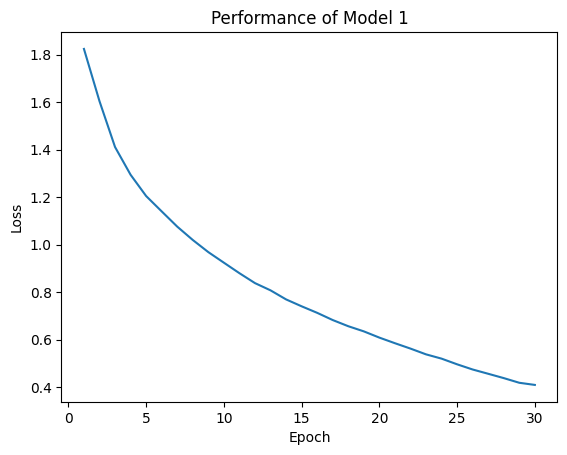

In [36]:
plt.plot(range(1,n_epochs +1), train_losslist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of Model 1')
plt.show()

# <span style="color:#d64161; font-family: Trebuchet MS; font-size: 40px; font-weight: bold;">Predictions</span>

In [37]:
# Track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# Iterate over test data
for data, target in test_loader:
    if train_on_gpu:
       data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range (batch_size) :
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s:  %2d%%  (%2d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))
  else :
      print('Test Accuracy of %5s: N/A (no training examples)') % (classes[i])
print('\nTest Accuracy (Overall) : %2d%%  (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.814183

Test Accuracy of airplane:  83%  (839/1000)
Test Accuracy of automobile:  84%  (840/1000)
Test Accuracy of  bird:  66%  (661/1000)
Test Accuracy of   cat:  48%  (483/1000)
Test Accuracy of  deer:  70%  (709/1000)
Test Accuracy of   dog:  65%  (653/1000)
Test Accuracy of  frog:  81%  (816/1000)
Test Accuracy of horse:  79%  (793/1000)
Test Accuracy of  ship:  80%  (800/1000)
Test Accuracy of truck:  81%  (810/1000)

Test Accuracy (Overall) : 74%  (7404/10000)
